## Éléments essentiels de la version de production

Dans ce chapitre, vous découvrirez le pipeline d'intégration continue et de livraison continue (CI/CD), les éléments essentiels d'un environnement de production et comment configurer un environnement de production pour servir votre apprentissage automatique précédemment testé et approuvé (ML ) aux utilisateurs finaux. 

Nous allons configurer l'infrastructure requise pour l'environnement de production du pipeline CI/CD, configurer les processus pour les déploiements de production, configurer les déclencheurs d'exécution du pipeline pour une automatisation complète et apprendre à gérer les versions de production.


 Ce chapitre couvrira les principes fondamentaux essentiels du pipeline CI/CD et de l'environnement de production puisque le pipeline est le produit et non le modèle. En vous familiarisant avec les principes fondamentaux des pipelines CI/CD, vous serez en mesure de développer, tester et configurer des pipelines CI/CD automatisés pour vos cas d'utilisation ou votre entreprise. Nous couvrirons un éventail de sujets autour des déploiements de production, puis nous aborderons un aperçu de la surveillance des modèles de ML en production

 Nous allons couvrir les sujets suivants dans ce chapitre : 
 
* Configuration de l'infrastructure de production

* Configuration de notre environnement de production dans le pipeline CI/CD

* Test de notre pipeline prêt pour la production 

* Configuration des déclencheurs de pipeline pour l'automatisation

* Gestion des versions du pipeline

* Vers une surveillance continue du service 

Commençons par mettre en place l'infrastructure nécessaire à la construction du pipeline CI/CD.

## Mise en place de l'infrastructure de production

Dans cette section, nous allons mettre en place l'infrastructure requise pour servir notre cas d'utilisation commerciale (pour prévoir les conditions météorologiques - il pleut ou ne pleut pas au port de Turku pour planifier et optimiser les ressources au port). 

Nous allons mettre en place un cluster Kubernetes autoscaling pour déployer notre modèle de ML sous la forme d'un service Web. Kubernetes est un système d'orchestration de conteneurs open source permettant d'automatiser le déploiement, la mise à l'échelle et la gestion des applications logicielles. 


De nombreux fournisseurs de services cloud proposent une infrastructure basée sur Kubernetes en tant que service. De même, Microsoft Azure fournit une infrastructure basée sur Kubernetes en tant que service appelée Azure Kubernetes Service (AKS). Nous utiliserons AKS pour orchestrer notre infrastructure. Il existe plusieurs façons de provisionner un cluster Kubernetes autoscalable sur Azure. Nous explorerons les deux manières suivantes pour en savoir plus sur les différentes perspectives de provisionnement d'infrastructure : 

* Portail de l'espace de travail Azure Machine Learning 

* Azure SDK 

Voyons d'abord la manière la plus simple ; c'est-à-dire en utilisant l'espace de travail Azure Machine Learning pour provisionner un cluster Azure Kubernetes pour la production

## Espace de travail Azure Machine Learning

Dans cette section, nous allons provisionner un cluster Azure Kubernetes à l'aide de l'espace de travail Azure Machine Learning. Effectuez les étapes suivantes : 

1. Accédez à l'espace de travail Azure Machine Learning, puis à la section Calculer (Compute), qui présente des options pour créer différents types de calculs. Sélectionnez les clusters d'inférence (Inference clusters ) et cliquez sur Créer, comme illustré dans la capture d'écran suivante :

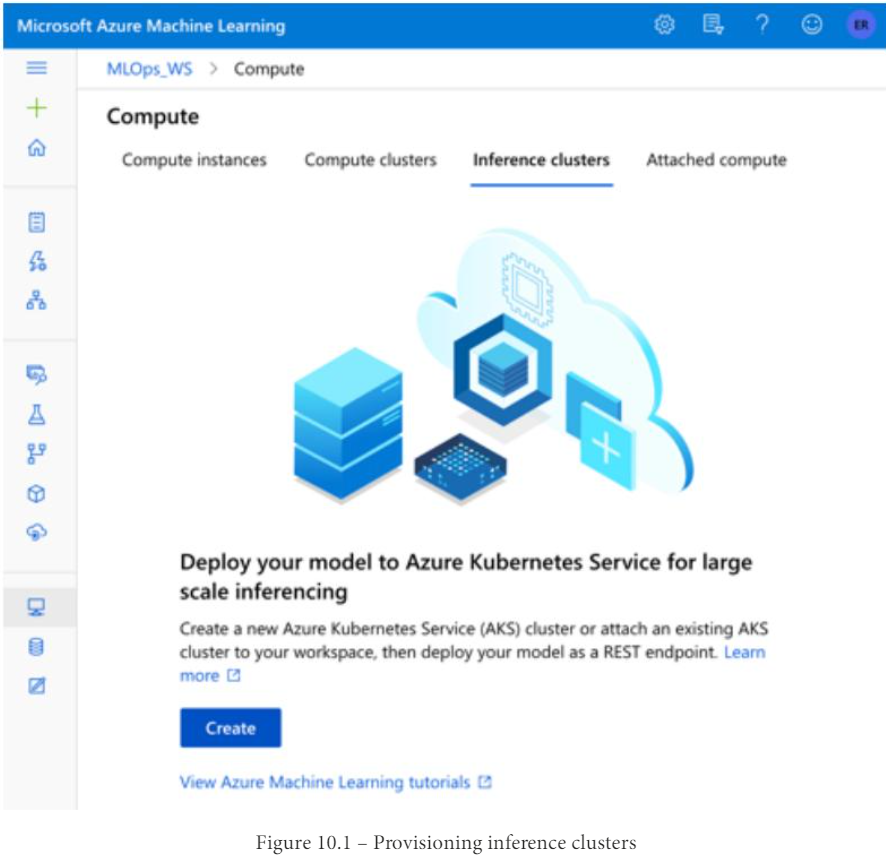

2. Cliquer sur le bouton Créer présentera diverses options de calcul que vous pouvez utiliser pour créer un service Kubernetes. Vous serez invité à sélectionner une région (Region), où votre calcul sera provisionné, et une certaine configuration afin que vous puissiez provisionner en termes de cœurs, de RAM et de stockage. Sélectionnez une option appropriée (il est recommandé de sélectionner Standard_D2_v4 comme choix optimal en termes de coût pour cette expérience), comme illustré dans la capture d'écran suivante :

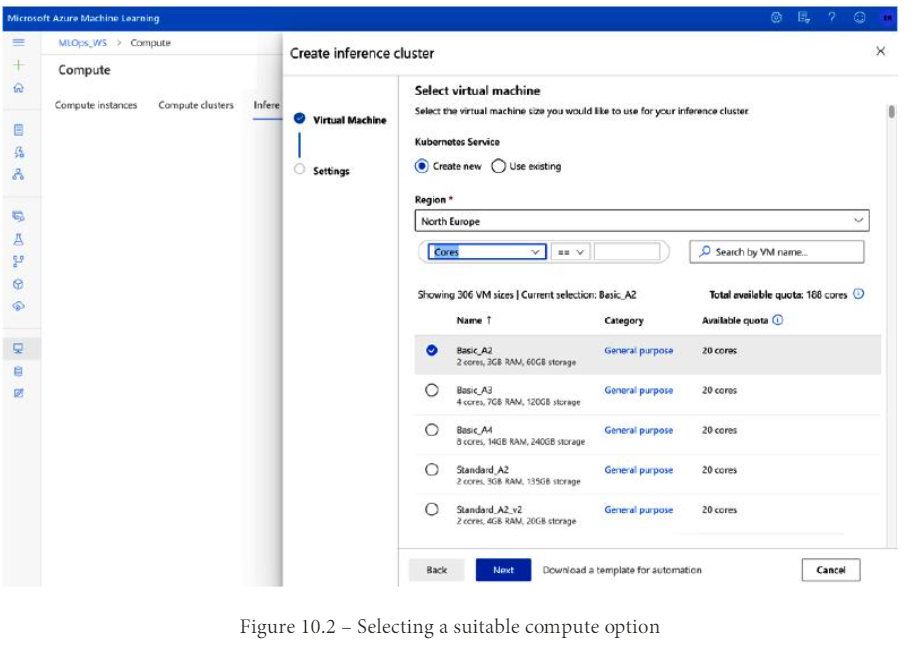

3. Après avoir sélectionné une option de calcul appropriée, vous serez invité à Configurer les paramètres (onfugure Settings ) du cluster, comme illustré dans la capture d'écran suivante. Nommez notre calcul (compute) (par exemple, 'prod-aks' - ce qui signifie production Azure Kubernetes Service), définissez l'objectif du cluster (Cluster purpose) sur Production (comme nous le préparons pour la production), choisissez Nombre de nœuds pour le cluster et sélectionnez l'option De base(Basic ) pour Réseau configuration (Network conguration). Omettre Activer la configuration SSL pour plus de simplicité. Cependant, il est recommandé d'activer les connexions SSL pour plus de sécurité en production, selon vos besoins :

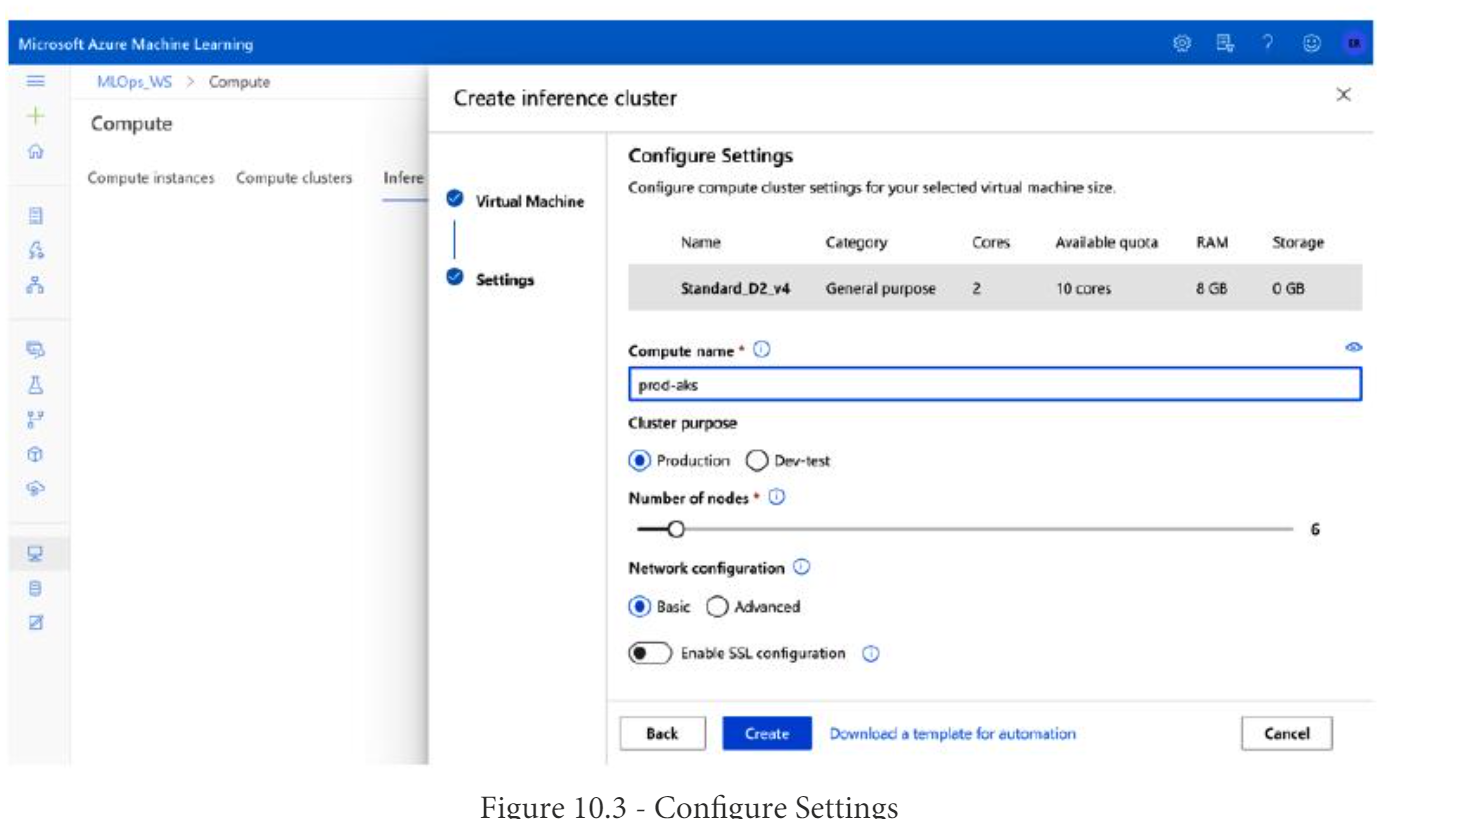

4. Cliquez sur le bouton Créer pour provisionner le cluster Kubernetes pour la production. Il faudra environ 15 minutes pour créer et provisionner le calcul pour une utilisation en production :

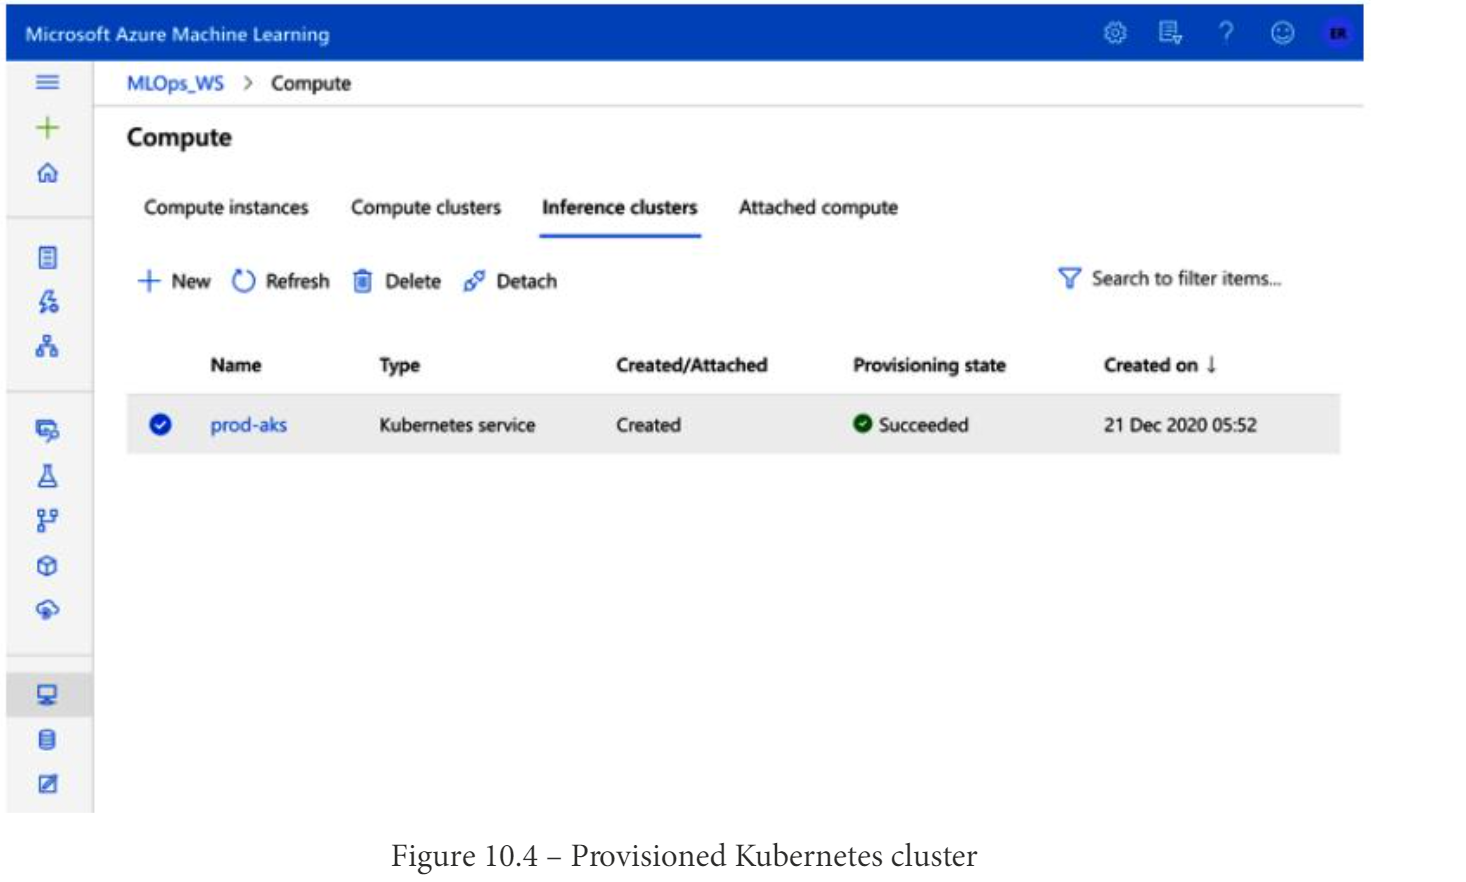

5. Une fois votre cluster AKS provisionné, vous verrez un cluster Kubernetes en cours d'exécution avec le nom que vous avez fourni pour le calcul (par exemple, prod-aks), comme indiqué dans la capture d'écran précédente.

## Azure Machine Learning SDK

Une autre façon de créer et de provisionner un cluster Kubernetes sur Azure consiste à utiliser Azure Machine Learning SDK. Vous pouvez utiliser un script prédéfini nommé create_aks_cluster.py, qui se trouve dans le dossier 10_Production_Release. La condition préalable à l'exécution du script create_aks_cluster.py est le fichier config.json (il peut être téléchargé à partir de l'espace de travail Azure Machine Learning) pour votre espace de travail Azure Machine Learning, comme illustré dans la capture d'écran suivante :


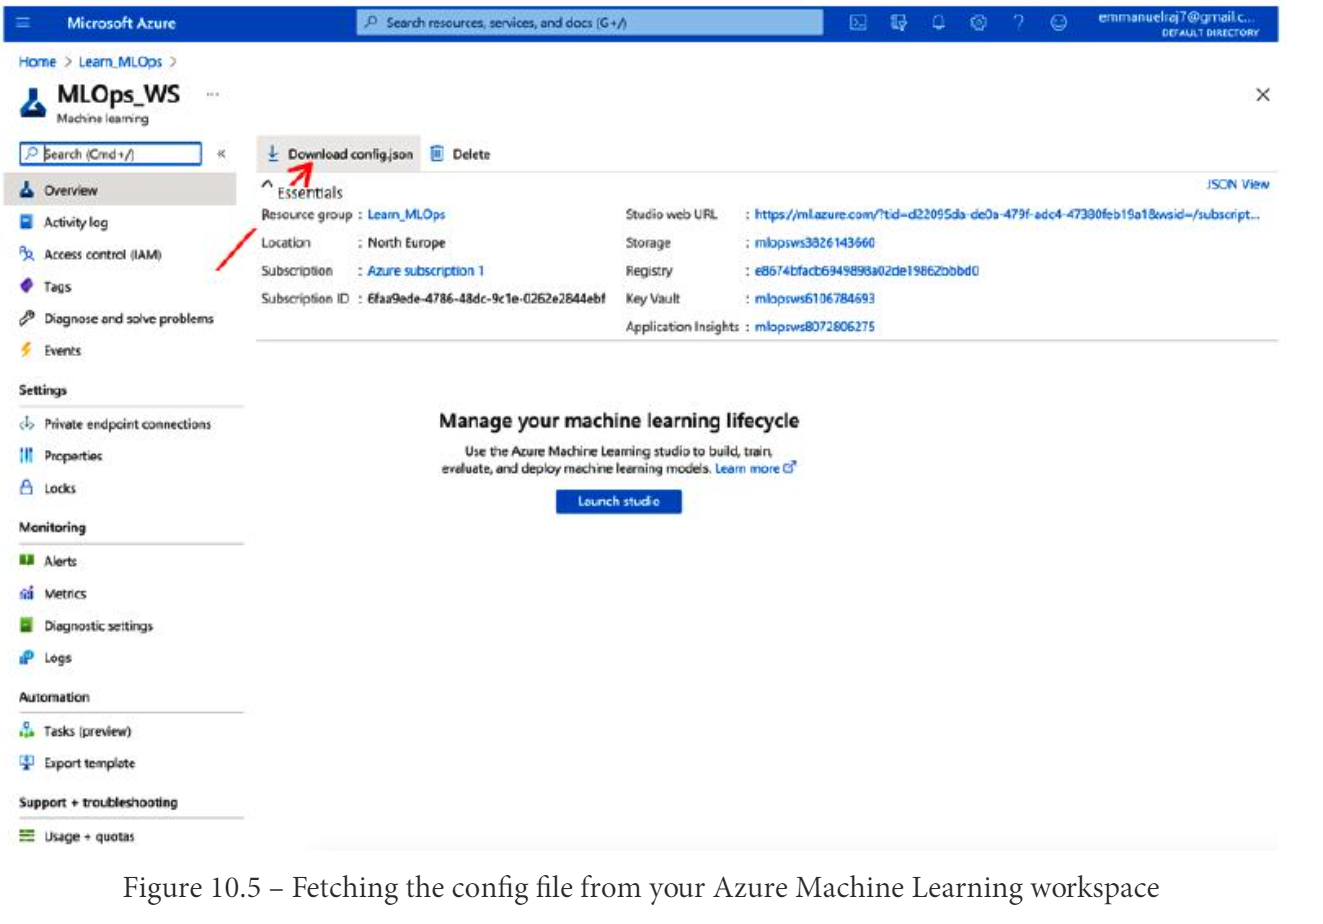

Accédez à votre espace de travail Azure Machine Learning et cliquez sur Télécharger config.json pour télécharger votre fichier de configuration. Après l'avoir téléchargé, copiez ou déplacez le fichier config.json dans le même répertoire (10_Production_Release) que le fichier create_aks_cluster.py, comme indiqué ici :



      ├──10_Production_Release
      ├── create_aks_cluster.py
      ├── config.json

Avec cela, vous êtes maintenant configuré pour exécuter le script (create_aks_cluster.py) pour créer le calcul AKS pour les déploiements de production. Examinons le script create_aks_cluster.py : 

1. Importez les fonctions nécessaires à partir du SDK ou de la bibliothèque azureml.core. Des fonctions telles que Workspace, Model, ComputeTarget, AksCompute, etc. seront utilisées pour provisionner votre cluster AKS :

In [ ]:
import numpy as np
import azureml.core
from azureml.core import Workspace
from azureml.core.model import Model
from azureml.core.compute import ComputeTarget
from azureml.core.compute_target import ComputeTargetException
from azureml.core.compute import AksCompute, 

2. En important les fonctions nécessaires, vous pouvez commencer à les utiliser en vous connectant à votre espace de travail Azure Machine Learning et en créant l'objet ws. Pour ce faire, utilisez la fonction Workspace et pointez-la vers votre fichier config.json, comme ceci :

In [ ]:
ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, sep = '\n')

3. Par défaut, la fonction from_config() recherche le fichier config.json dans le même répertoire que celui où vous exécutez le fichier create_aks.py. Si votre fichier config.json se trouve à un autre emplacement, pointez sur l'emplacement du fichier dans la fonction from_config(). Après avoir exécuté avec succès la fonction workspace.from_config(), vous verrez le nom de l'espace de travail, le groupe de ressources et l'emplacement imprimés.


4. Ensuite, nous allons créer un cluster AKS Kubernetes pour les déploiements de production. Commencez par choisir un nom pour votre cluster AKS (référencez-le à la variable aks_name), tel que prod-aks. Le script vérifiera si un cluster avec le nom choisi existe déjà. Nous pouvons utiliser l'instruction try pour vérifier si la cible AKS avec le nom choisi existe en utilisant la fonction ComputeTarget(). Il prend l'objet de l'espace de travail et aks_name comme paramètres. Si un cluster est trouvé avec le nom choisi, il imprimera le cluster qui a été trouvé et arrêtera l'exécution. Sinon, un nouveau cluster sera créé à l'aide de la fonction ComputeTarget.create(), qui prend la configuration de provisionnement avec la configuration par défaut :

In [ ]:
# Choose a name for your AKS cluster
aks_name = 'prod-aks' 

# Verify that cluster does not exist already
try:
    aks_target = ComputeTarget(workspace=ws, name=aks_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    # Use the default configuration (can also provide parameters to customize)
    prov_config = AksCompute.provisioning_configuration()

    # Create the cluster
    aks_target = ComputeTarget.create(workspace = ws, 
                                    name = aks_name, 
                                    provisioning_configuration = prov_config)

if aks_target.get_status() != "Succeeded":
    aks_target.wait_for_completion(show_output=True)

Après avoir exécuté avec succès le code précédent, un nouveau cluster avec le nom choisi (c'est-à-dire prod-aks) sera créé. Généralement, la création d'un nouveau cluster prend environ 15 minutes. Une fois le cluster créé, il peut être repéré dans l'espace de travail Azure Machine Learning, comme nous l'avons vu dans la figure 10.4. Maintenant que nous avons configuré les prérequis pour améliorer le pipeline CI/CD pour notre environnement de production, commençons à le configurer !

## Configuration de notre environnement de production dans le pipeline CI/CD

Effectuez les étapes suivantes pour configurer un environnement de production dans le pipeline CI/CD : 

1. Accédez au projet Azure DevOps sur lequel vous avez travaillé précédemment et revisitez les Pipelines | Releases pour afficher votre pipeline Port Weather ML Pipeline. Nous allons enrichir ce pipeline en créant une étape de production. 

2. Cliquez sur le bouton Modifier (Edit ) pour commencer et cliquez sur Ajouter c(add) sous l'étape DEV TEST, comme illustré dans la capture d'écran suivante :

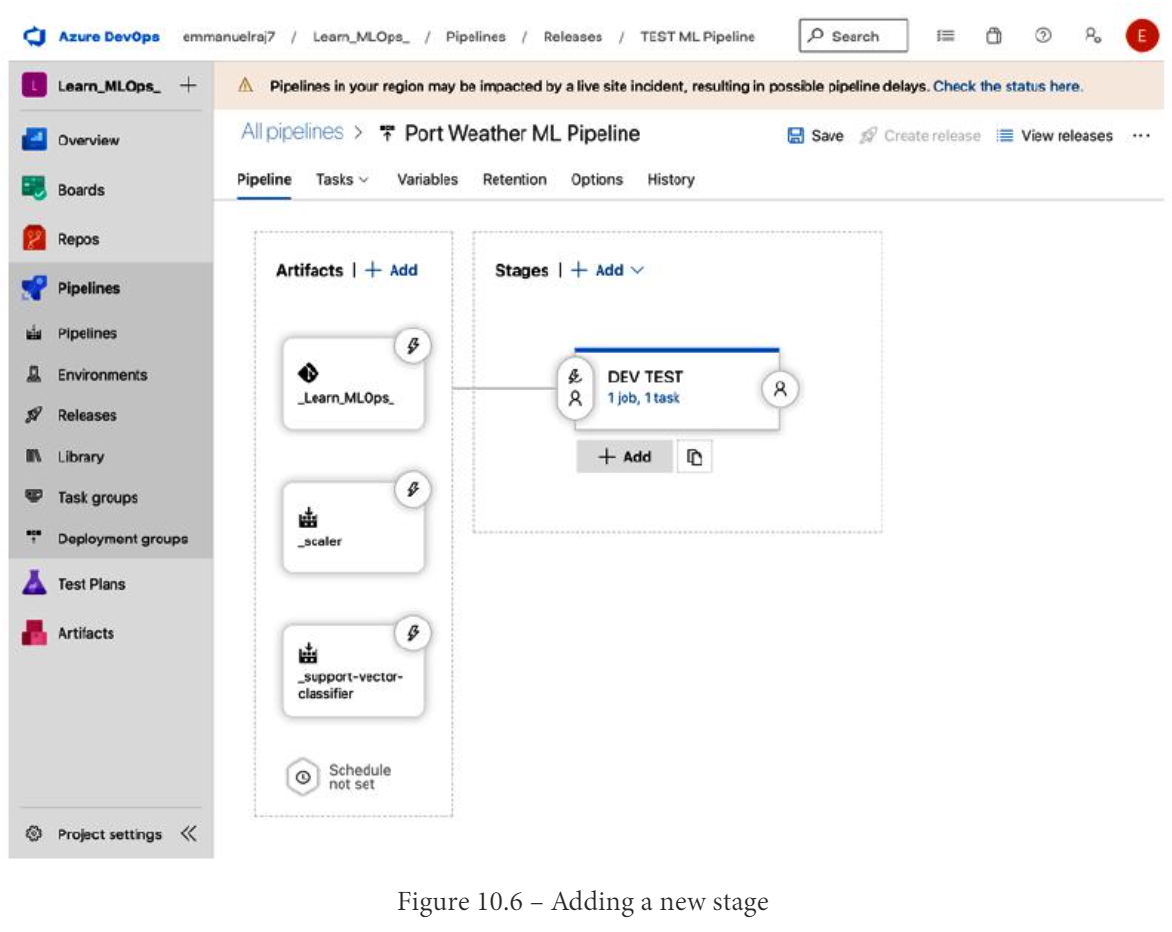

3. En cliquant sur le bouton Ajouter (add) sous l'étape DEV TEST, vous serez invité à sélectionner un modèle pour créer une nouvelle étape. Sélectionnez l'option EMPTY JOB (sous Select a template text) et nommez la stage production ou PROD et enregistrez-la, comme illustré dans la capture d'écran suivante :

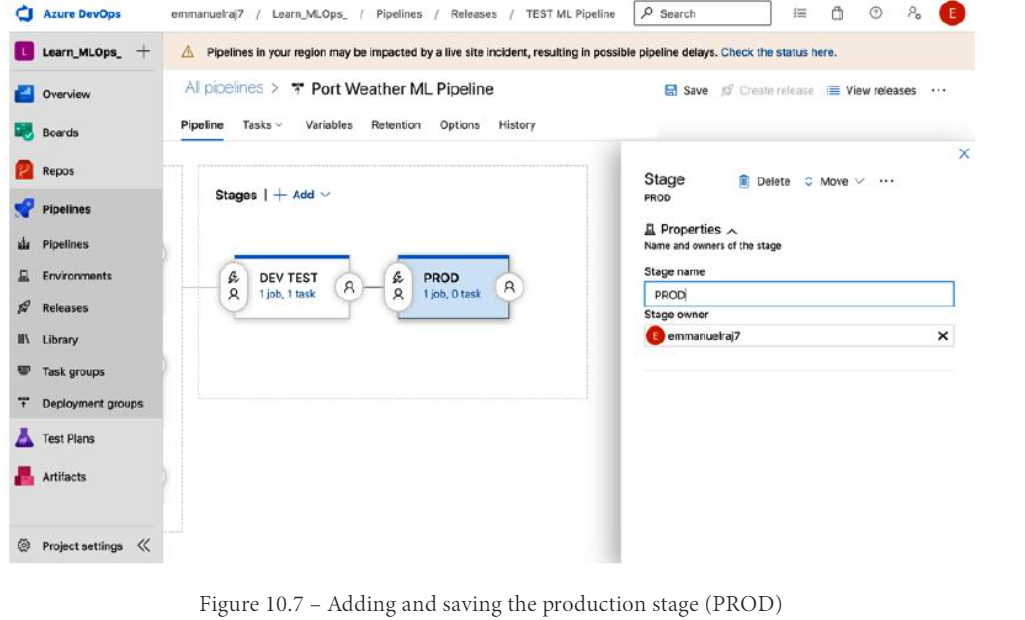

4. Une nouvelle étape de production nommée PROD sera créée. Désormais, vous pouvez configurer les tâches et les processus au stade de la production. 

Pour configurer des tâches pour PROD, cliquez sur le lien 1 tâche, 0 tâche (comme illustré dans la capture d'écran précédente, à l'étape PROD) dans l'étape PROD. Vous serez dirigé vers la section Tâches, où vous pouvez ajouter des tâches à l'étape PROD. À cette étape, nous déploierons des modèles à partir de notre espace de travail Azure Machine Learning, nous nous y connecterons donc à l'aide du modèle AzureML Model Deploy que nous avons utilisé précédemment dans le chapitre 7, Création de pipelines CI et CD robustes. Cliquez sur le signe + à droite de la section Travail Agent job pour ajouter une tâche, comme illustré ici :

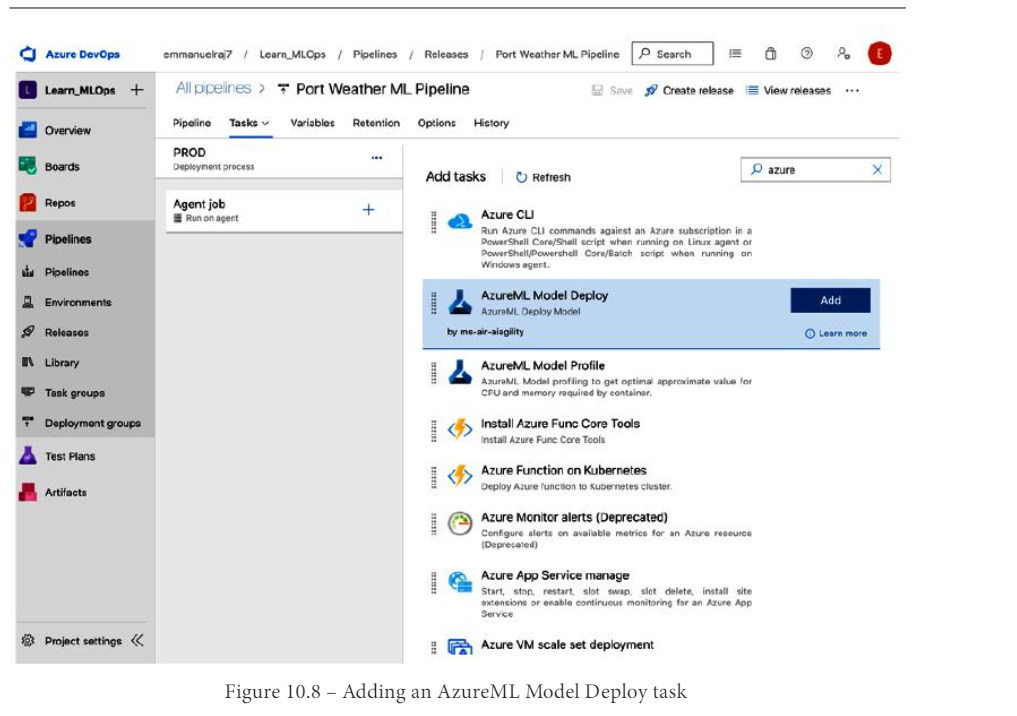

5. Recherchez le modèle ou la tâche AzureML Model Deploy et ajoutez-le. Après avoir ajouté la tâche, vous serez invité à la configurer en vous connectant à votre espace de travail Azure Machine Learning. Sélectionnez votre espace de travail Azure Machine Learning (par exemple, mlops_ws) et pointez sur Model Artifact comme source de modèle. Nous faisons cela parce que nous utiliserons les artefacts de modèle que nous avons formés au chapitre 4, Pipelines d'apprentissage automatique.

6. Ensuite, pointez sur votre fichier de configuration d'inférence à partir du référentiel Azure DevOps, comme illustré dans la capture d'écran suivante. Le fichier de configuration d'inférence représente les paramètres de configuration d'un environnement personnalisé utilisé pour le déploiement. Nous utiliserons le même fichier d'inférence Config.yml que nous avons utilisé pour l'environnement DEV TEST, car l'environnement de déploiement doit être le même :

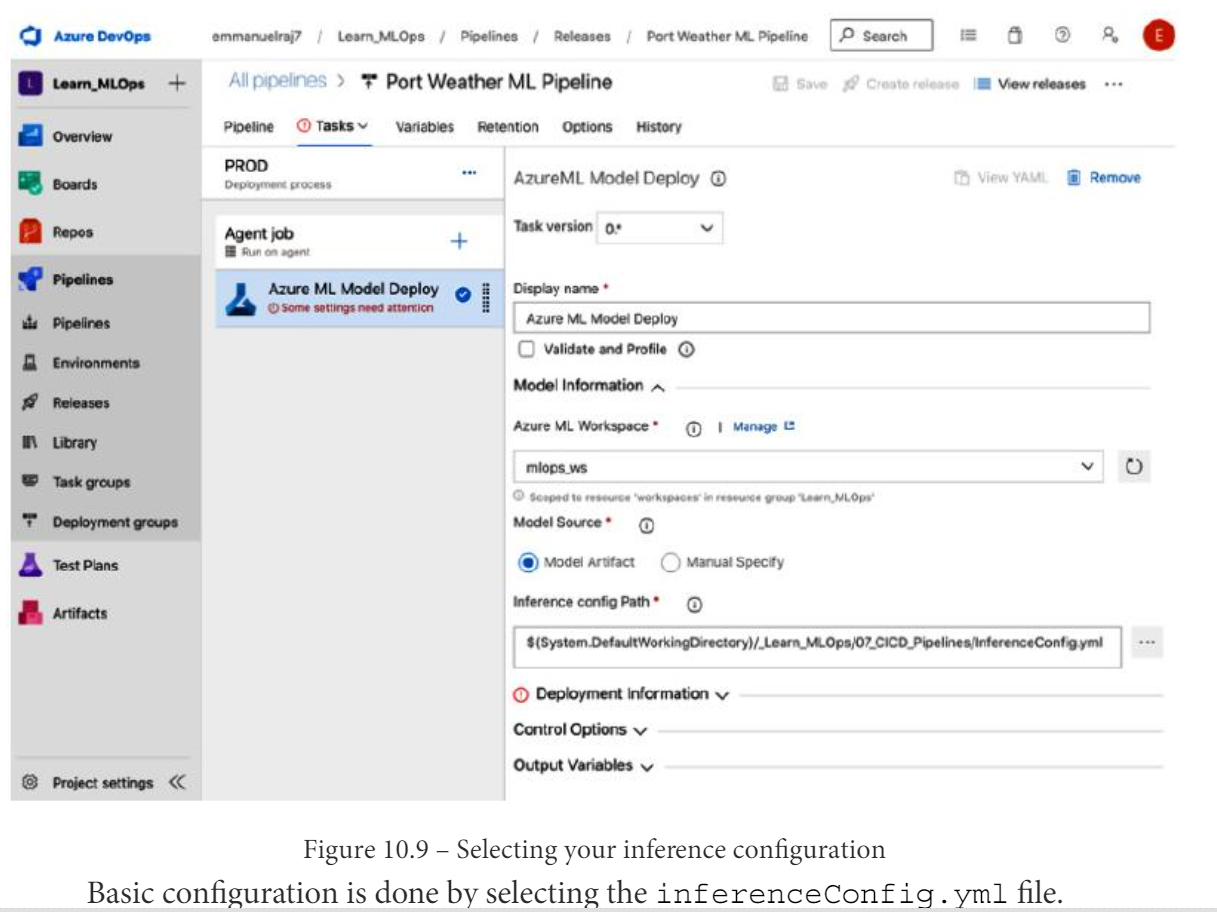

7. Ensuite, nous allons configurer les informations de déploiement (Deployment Information) en spécifiant le type de cible de déploiement comme Azure Kubernetes Service. Nous faisons cela parce que c'est l'environnement de production que nous utiliserons pour faire évoluer automatiquement notre cluster Kubernetes pour les déploiements de production. Après avoir sélectionné le service Azure Kubernetes comme cible de déploiement, sélectionnez le cluster AKS que vous avez créé précédemment (par exemple, prod-aks), nommez votre déploiement ou service Web (par exemple, prod-webservice) et sélectionnez la configuration de déploiement  (Deployment Conguration)  Fichier du référentiel Azure DevOps connecté au pipeline, comme illustré ici :


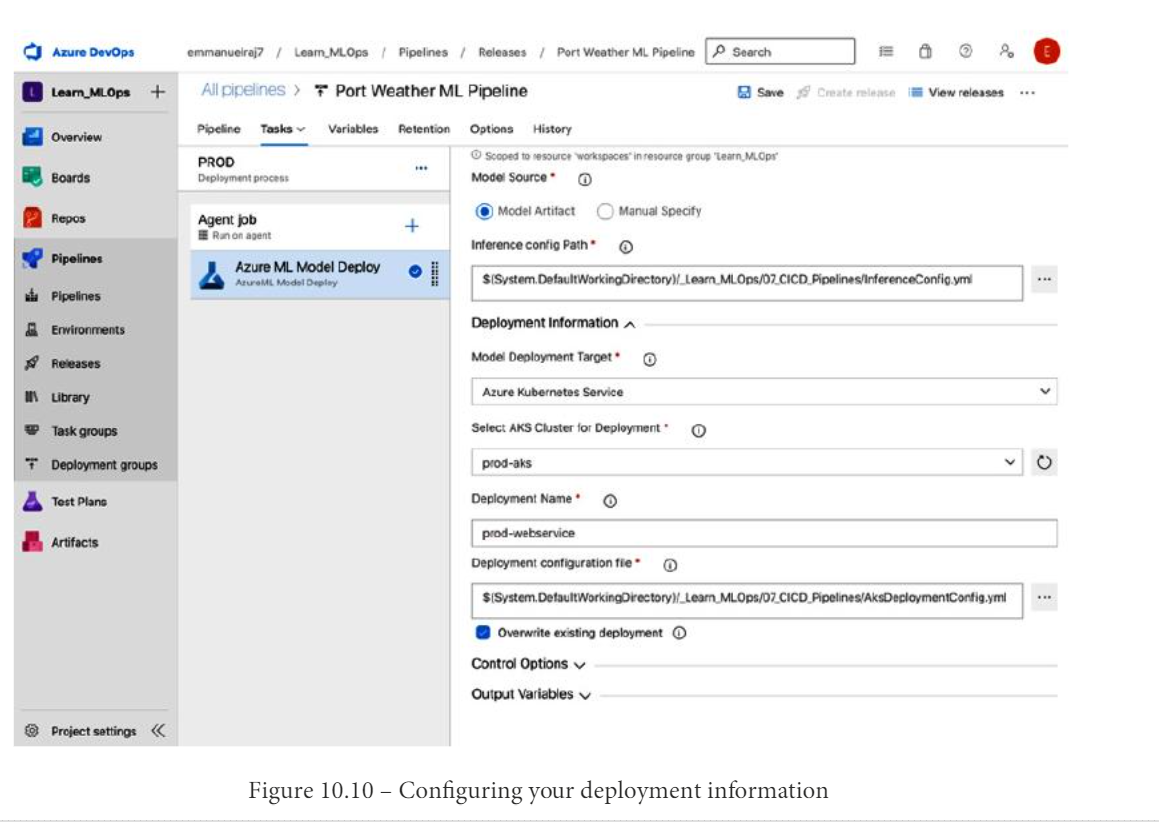

Le fichier de configuration de déploiement que nous utiliserons pour l'environnement de production s'appelle AksDeploymentConfig.yml. Il contient les détails de la configuration pour notre déploiement, y compris l'activation de l'autoscaling avec un nombre minimum et maximum de réplicas, la configuration de l'authentification, la surveillance de la configuration et les besoins en ressources du conteneur avec le processeur (pour d'autres situations où l'inférence doit être très rapide ou un traitement en mémoire plus important est nécessaire, vous pouvez envisager d'utiliser une ressource GPU) et les besoins en mémoire, comme indiqué ici :


    computeType: AKS
    autoScaler:
        autoscaleEnabled: True
        minReplicas: 1
        maxReplicas: 3
        refreshPeriodInSeconds: 10
        targetUtilization: 70
    authEnabled: True
    containerResourceRequirements:
        cpu: 1
        memoryInGB: 1
    appInsightsEnabled: True
    scoringTimeoutMs: 1000
    maxConcurrentRequestsPerContainer: 2
    maxQueueWaitMs: 1000
    sslEnabled: False

8. Sélectionnez le fichier AksDeploymentConfig.yml comme fichier de configuration de déploiement. Maintenant, appuyez sur le bouton Enregistrer pour configurer l'environnement PROD.


Avec cela, vous avez configuré avec succès l'environnement de production et l'avez intégré à votre pipeline CI/CD pour l'automatisation. Maintenant, testons le pipeline en l'exécutant

## Test de notre pipeline prêt pour la production

Félicitations pour la mise en place du pipeline de production ! Ensuite, nous testerons sa robustesse. Un excellent moyen de le faire est de créer une nouvelle version et d'observer et d'étudier si le pipeline de production déploie avec succès le modèle en production (dans la configuration du cluster Kubernetes de production contenant le pipeline).

 Suivez ces étapes pour tester le pipeline : 
 
 1. Tout d'abord, créez une nouvelle version, accédez à Pipelines | Dans la section Versions  (Pipelines | Releases), sélectionnez votre pipeline précédemment créé (par exemple, Port Weather ML Pipeline), et cliquez sur le bouton Créer une version (Create Release) en haut à droite de l'écran pour lancer une nouvelle version, comme illustré ici :

 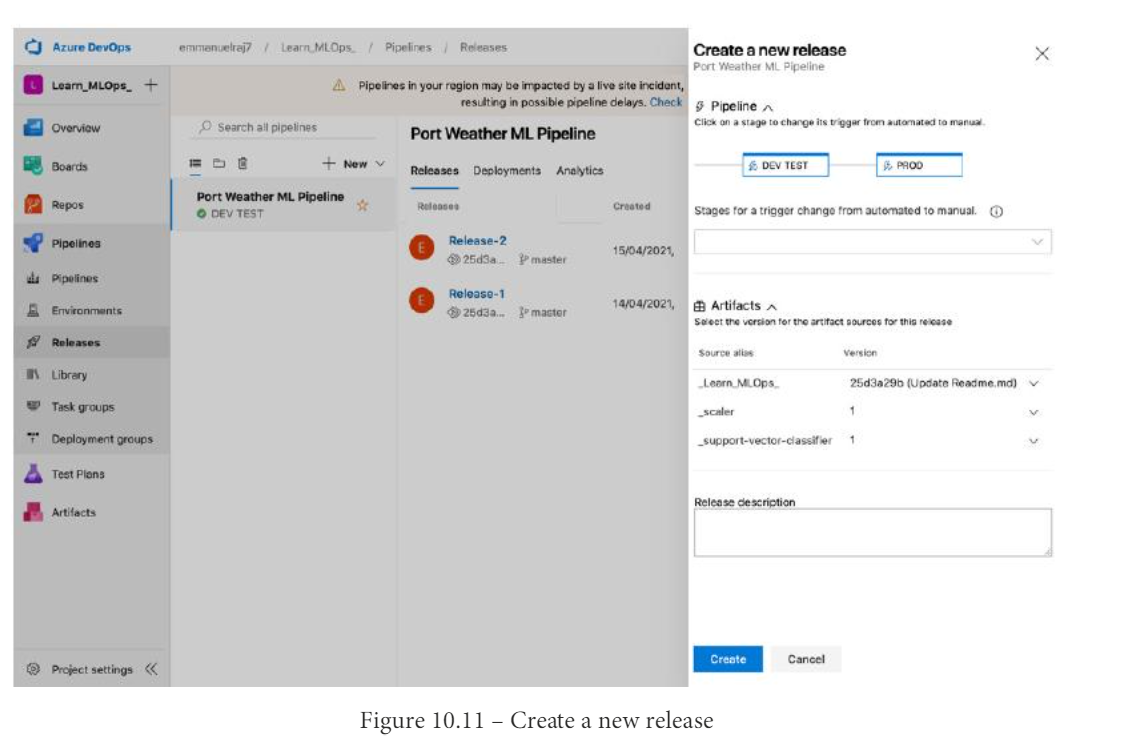

2. Sélectionnez les artefacts que vous souhaitez déployer dans le pipeline (par exemple, le référentiel Learn_MLOps, _scaler et support-vector-classifier model et sélectionnez leurs versions. La version 1 est recommandée pour tester les déploiements PROD pour la première fois), et cliquez sur le bouton Créer en haut à droite de l'écran, comme illustré dans la capture d'écran précédente. Une fois que vous avez fait cela, une nouvelle version est lancée, comme illustré dans la capture d'écran suivante :

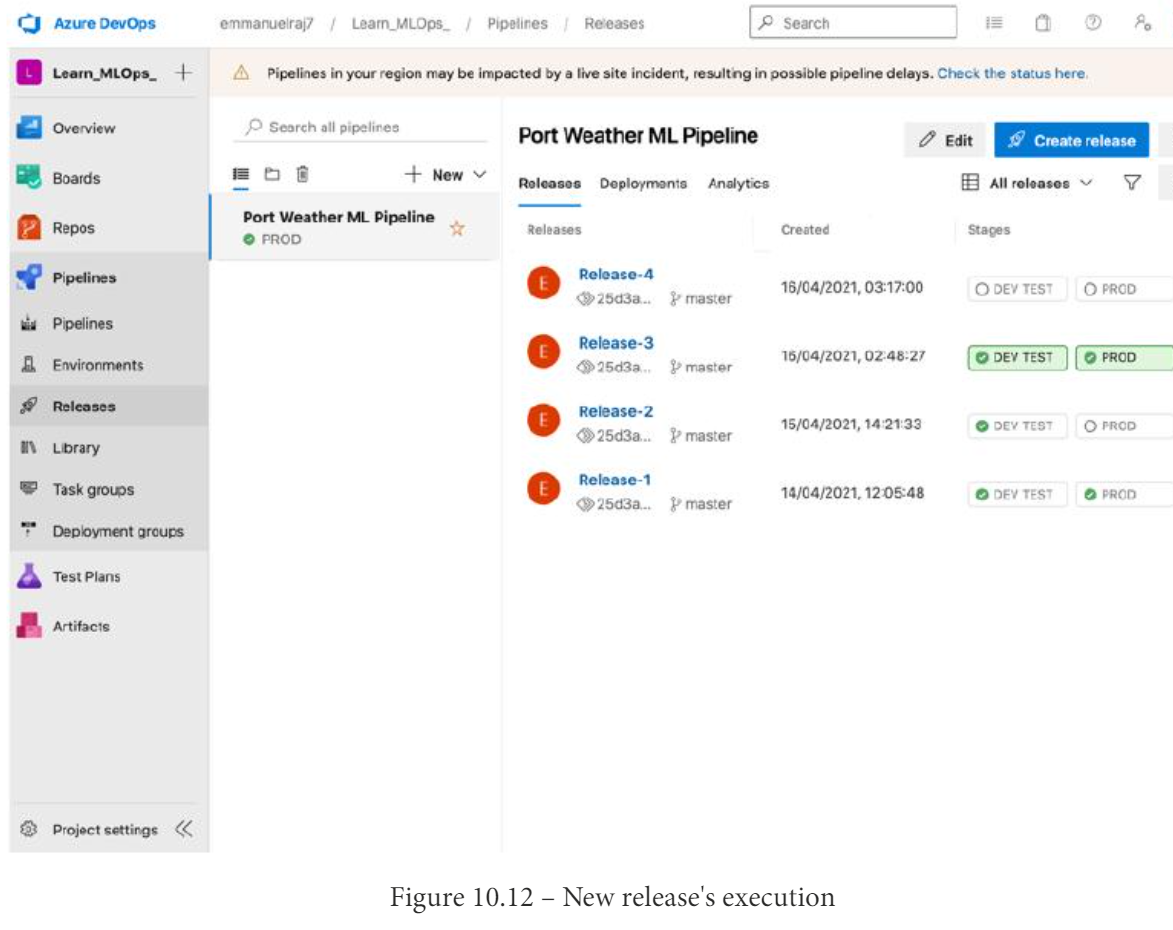

3. Après l'exécution du pipeline, les étapes DEV TEST et PROD seront déployées (par exemple, Release-5, comme illustré dans la capture d'écran précédente). Vous pouvez vérifier chaque étape de chaque étape en surveillant les journaux de chaque étape de n'importe quelle étape (DEV TEST ou PROD) pendant que la version du pipeline est en cours, jusqu'à ce que le pipeline soit déployé avec succès. Vous pouvez également consulter les journaux des versions précédentes.


4. Après avoir travaillé avec succès sur une version, les étapes DEV TEST et PROD seront déployées à l'aide de CI et de CD. Vous devez vous assurer que le pipeline est robuste. Ensuite, nous pouvons personnaliser davantage le pipeline en ajoutant des déclencheurs personnalisés qui automatiseront le pipeline sans aucune supervision humaine. L'automatisation des pipelines CI/CD sans aucune supervision humaine peut être risquée mais peut présenter des avantages, tels que l'apprentissage continu en temps réel (modèles de surveillance et de recyclage) et des déploiements plus rapides. Il est bon de savoir comment automatiser le pipeline CI/CD sans aucune supervision humaine dans la boucle. Notez qu'il n'est pas recommandé dans de nombreux cas car il y a beaucoup de place pour l'erreur. Dans certains cas, cela peut être utile - cela dépend vraiment de votre cas d'utilisation et des objectifs du système ML. Examinons maintenant les déclencheurs pour une automatisation complète

## Configuration des déclencheurs de pipeline pour l'automatisation

Dans cette section, nous allons configurer trois déclencheurs en fonction des artefacts que nous avons déjà connectés au pipeline. Les déclencheurs que nous allons mettre en place sont les suivants : 

* Déclencheur Git : pour apporter des modifications au code de la branche principale.

* Déclencheur d'artefact : lorsqu'un nouveau modèle ou artefact est créé ou formé.

* Déclencheur de planification : un déclencheur périodique hebdomadaire. Regardons chacun de ces déclencheurs de pipeline en détail

## Configuration d'un déclencheur Git 

Dans les équipes, il est courant de définir un déclencheur pour le déploiement lorsque des modifications de code sont apportées à une certaine branche du référentiel. Par exemple, lorsque des modifications de code sont apportées à la branche principale ou à la branche de développement, les pipelines CI/CD sont déclenchés pour déployer l'application dans les environnements PROD ou DEV TEST, respectivement. Lorsqu'une pull request est faite pour fusionner le code dans la branche master ou develop, l'expert QA ou le chef de produit accepte la pull request afin de fusionner avec la branche respective. Lors de la modification du code de la branche master ou develop, un déclencheur est généré pour créer une nouvelle version dans le pipeline. Suivez ces étapes pour créer un déclencheur pour la branche principale de l'expérience, comme illustré dans la capture d'écran suivante : 

1. Accédez à la section Pipelines | Releases et sélectionnez votre pipeline (par exemple, pipeline Port Weather ML). Ensuite, cliquez sur Modifier (edit) :

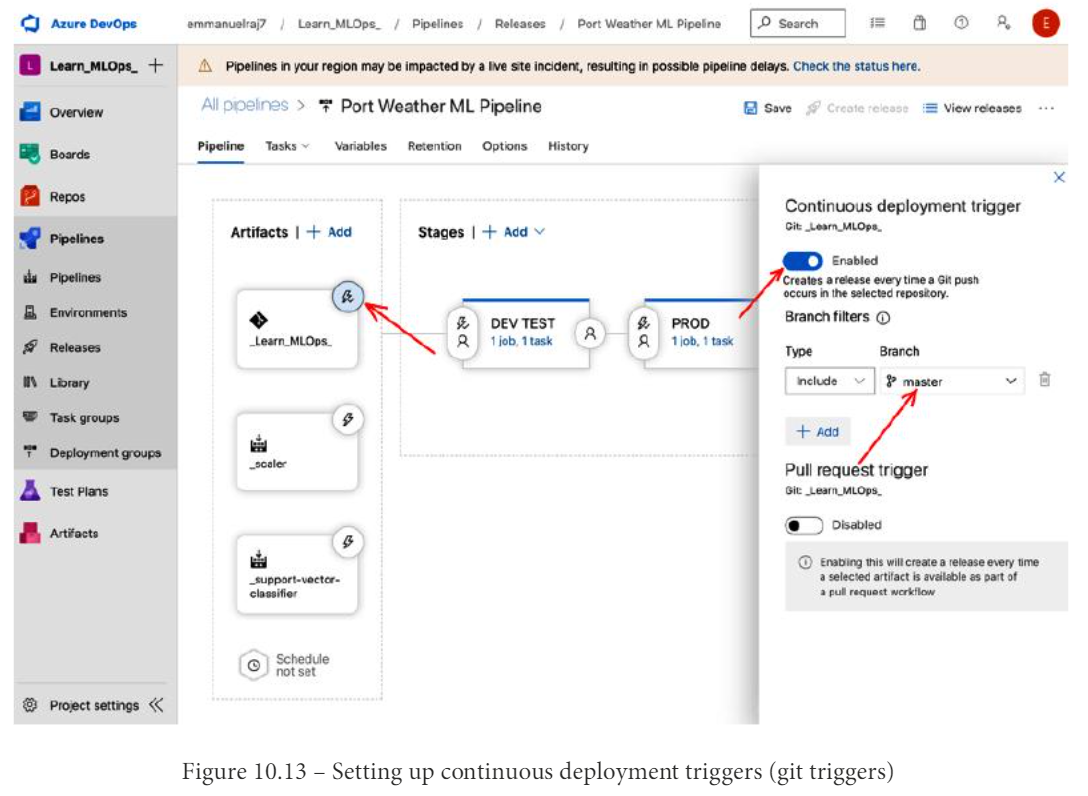

Vous serez dirigé vers un portail où vous pourrez modifier votre pipeline (par exemple, Port Weather ML pipeline) afin de pouvoir configurer des déclencheurs de déploiement continu pour vos artefacts.


2. Pour configurer un déclencheur Git pour la branche master (lorsque des modifications sont apportées à la branche master, une nouvelle version est déclenchée), cliquez sur l'icône Trigger (icône tonnerre) et déplacez le bouton marche/arrêt de désactivé à activée. Cela activera le déclencheur de déploiement continu. 

3. Enfin, ajoutez un filtre de branche et pointez sur la branche pour laquelle vous souhaitez configurer un déclencheur – dans ce cas, la branche principale – comme indiqué dans la capture d'écran précédente. Enregistrez vos modifications pour configurer le déclencheur Git.

En implémentant ces étapes, vous avez configuré un déclencheur de déploiement continu pour lancer une nouvelle version lorsque des modifications sont apportées à la branche principale

## Configuration d'un déclencheur Artifactory

Pour les applications ML, les déclencheurs Artifactory sont très utiles. Lorsque de nouveaux modèles ou artefacts (fichiers) ont été formés par les Data Scientists de l'équipe, il est utile de déployer ces modèles dans un environnement de test, puis éventuellement en production s'ils sont prometteurs ou meilleurs que les modèles ou déclencheurs précédents. Suivez ces étapes pour configurer un déclencheur de déploiement continu qui créera une nouvelle version pour le pipeline lorsqu'un nouveau modèle est formé, comme illustré dans la capture d'écran suivante : 

1. Accédez aux pipelines | Section Releases et sélectionnez votre pipeline (par exemple, pipeline Port Weather ML). Ensuite, cliquez sur Modifier :

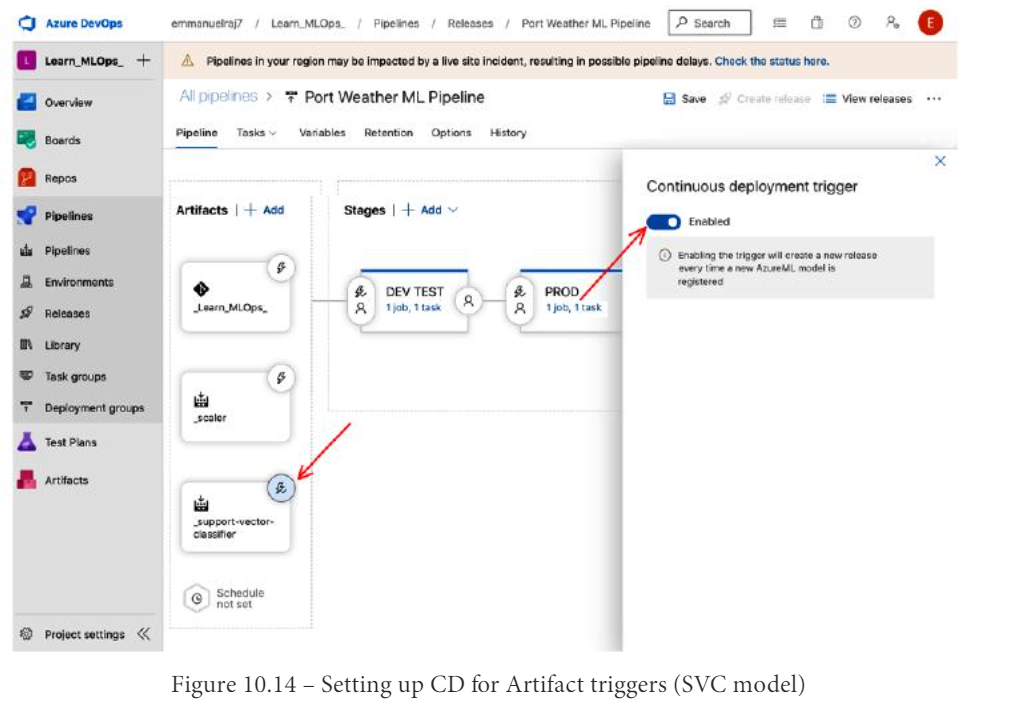

En cliquant sur le bouton Modifier, vous serez dirigé vers un portail où vous pourrez modifier votre pipeline, comme indiqué dans la capture d'écran précédente.

2. Pour configurer un déclencheur d'artefact pour votre modèle, cliquez sur le modèle de votre choix, tel que Support Vector Classifierer (SVC), et activez le déclencheur de déploiement continu. Dans la capture d'écran précédente, un déclencheur a été activé pour un modèle (SVC). Chaque fois qu'un nouveau modèle SVC est formé et enregistré dans le registre de modèles connecté à votre espace de travail Azure Machine Learning, une nouvelle version est déclenchée pour déployer le nouveau modèle via le pipeline. 

3. Enfin, enregistrez vos modifications pour configurer un déclencheur d'artefact pour le modèle SVC. Vous disposez d'un déclencheur de déploiement continu configuré pour lancer une nouvelle version lorsqu'un nouveau modèle SVC est formé et enregistré sur votre espace de travail Azure Machine Learning. Le pipeline récupérera le nouveau modèle et le déploiera dans les environnements DEV TEST et PROD


En implémentant ces étapes, vous disposez d'un déclencheur de déploiement continu configuré pour lancer une nouvelle version de pipeline lorsqu'un nouvel artefact est créé ou enregistré dans votre espace de travail Azure Machine Learning.

## Configuration d'un déclencheur de planification 

Maintenant, nous allons configurer un déclencheur de planification spécique dans le temps pour le pipeline. Ce type de déclencheur est utile pour maintenir le système sain et mis à jour via de nouvelles versions périodiques. 

Les déclencheurs de planification créent de nouvelles versions à des intervalles de temps définis. Nous allons configurer un déclencheur d'horaire pour chaque semaine le lundi à 11h00. À ce stade, une nouvelle version est déclenchée pour déployer la version récente du modèle SVC dans les environnements DEV TEST et PROD. Suivez ces étapes pour configurer un déclencheur de planification : 

1. Accédez à Pipelines | Section Releases et sélectionnez votre pipeline (par exemple, pipeline Port Weather ML). Ensuite, cliquez sur Modifier, comme illustré dans la capture d'écran suivante :

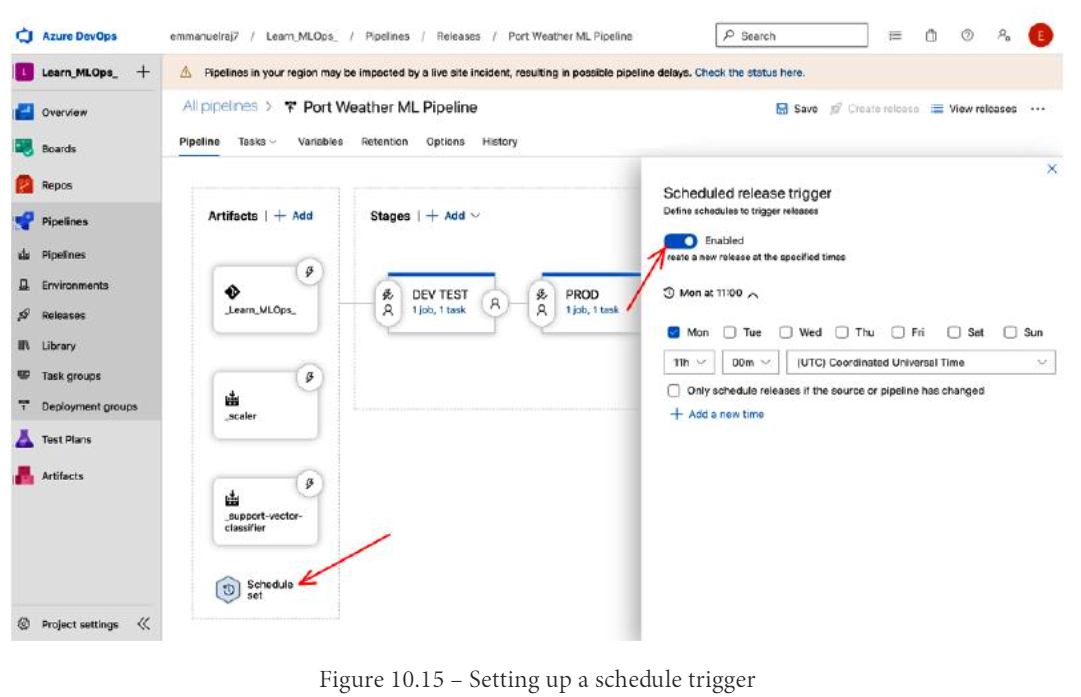

En cliquant sur le bouton Modifier, vous serez dirigé vers un portail où vous pourrez modifier votre pipeline. 

2. Pour configurer un déclencheur programmé pour le pipeline, cliquez sur (Schedule Set)  Définir le programme et activez le déclencheur de publication programmée (Scheduled release trigger).

 Ensuite, sélectionnez les moments où vous souhaitez déclencher une libération. Par exemple, dans la capture d'écran précédente, un déclencheur a été activé pour chaque semaine le lundi à 11h00. 
 
 3. Enfin, enregistrez vos modifications pour configurer un déclencheur de déclenchement de planification pour le pipeline.



En implémentant ces étapes, vous disposez d'un déclencheur de déploiement continu configuré pour lancer une nouvelle version de pipeline à un intervalle de temps défini. Félicitations pour la configuration des déclencheurs Git, Artefact et Schedule. Ces déclencheurs permettent une automatisation complète du pipeline. Le pipeline a été mis en place et peut désormais tester et déployer avec succès des modèles. Vous avez également la possibilité de semi-automatiser le pipeline en ajoutant un humain ou un expert en assurance qualité (QA) pour approuver chaque étape du pipeline. Par exemple, après l'étape de test, une approbation peut être faite par l'expert QA afin que vous puissiez démarrer le déploiement en production si tout a réussi à l'étape de test. En tant qu'expert en assurance qualité, il est essentiel de surveiller votre pipeline CI/CD. Dans la section suivante, nous examinerons quelques bonnes pratiques en matière de gestion des versions de pipeline.

## Gestion des versions du pipeline 

Les versions des pipelines CI/CD permettent à votre équipe d'automatiser entièrement et en continu la livraison des logiciels à vos clients plus rapidement et avec moins de risques. Les versions vous permettent de tester et de livrer votre logiciel à plusieurs étapes de production ou de mettre en place des processus semi-automatisés avec des approbations et des déploiements à la demande. Il est vital de surveiller et de gérer ces rejets. Nous pouvons gérer les versions en accédant au pipeline à partir de Pipelines | Releases et sélection de notre pipeline CI/CD (par exemple, Port Weather ML Pipeline), comme illustré dans la capture d'écran suivante :

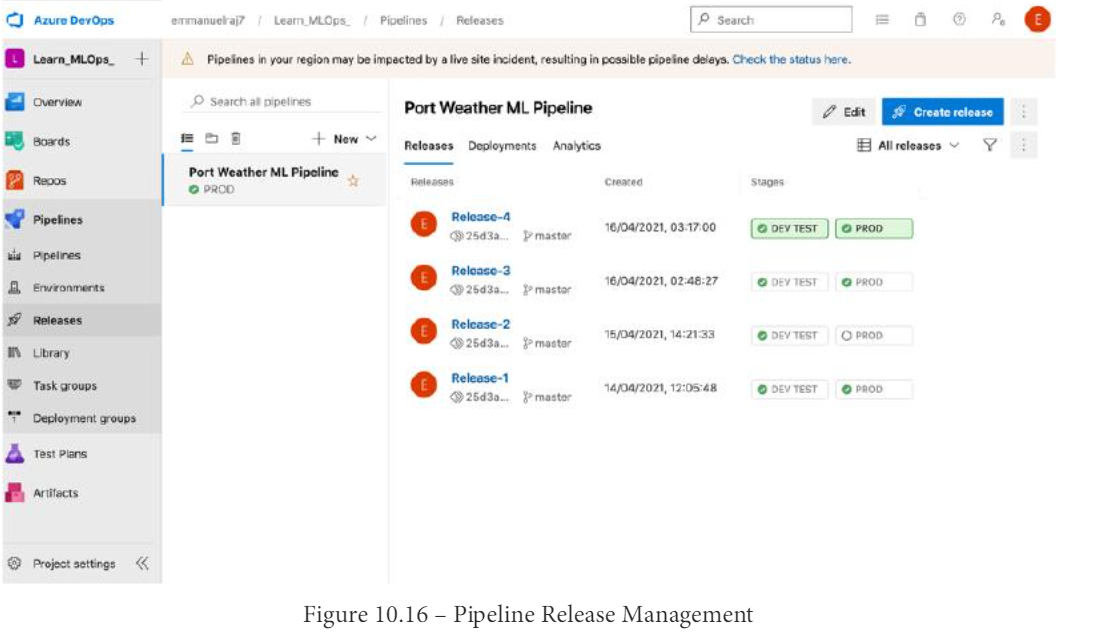

Ici, vous pouvez suivre toutes les versions et leur historique et effectuer des opérations pour chaque version, telles que le redéploiement, l'abandon, la vérification des journaux, etc. Vous pouvez voir les versions présentées dans la capture d'écran suivante. En cliquant sur des versions individuelles (par exemple, la version 4), nous pouvons vérifier quel modèle et quels artefacts ont été déployés dans la version et comment la version a été déclenchée (manuellement ou à l'aide de déclencheurs automatiques). Il offre une traçabilité de bout en bout du pipeline. Ces informations sont cruciales pour la gouvernance et la conformité du système de BC

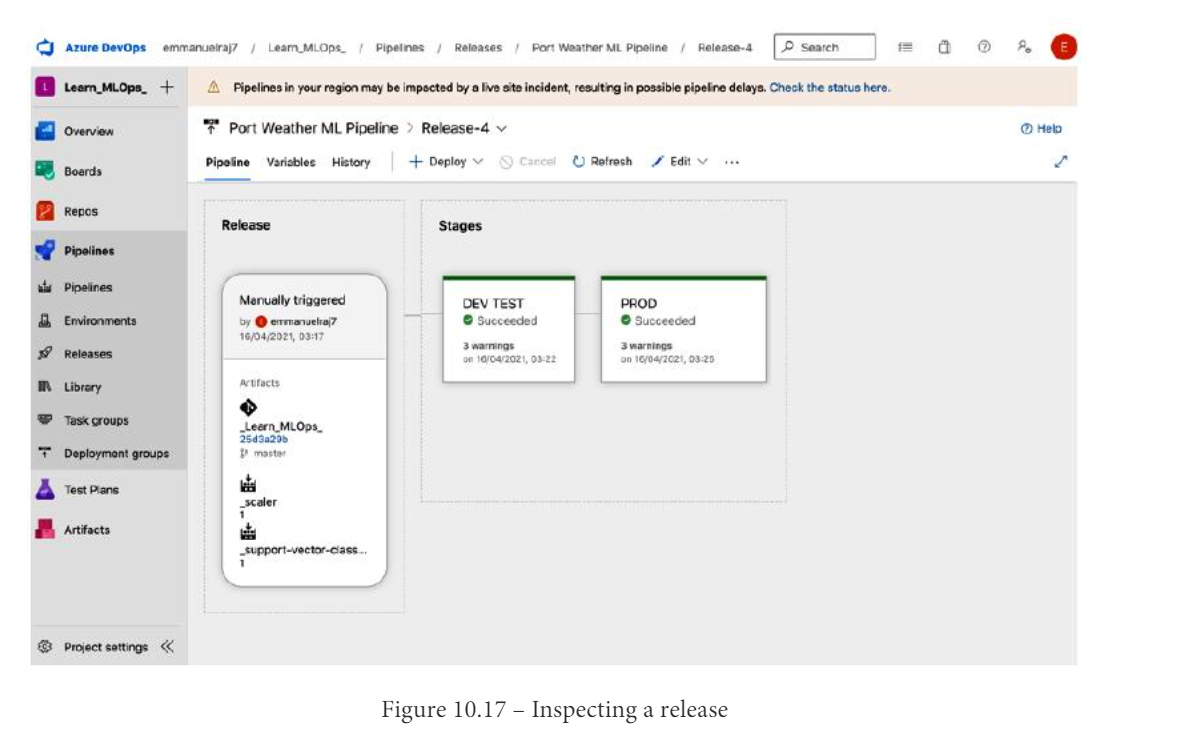

Mieux vaut prévenir que trouver un remède. Tout comme nous effectuons des revues d'incident après une panne, cela aide à prévenir les pannes possibles en effectuant des revues post-version après le déploiement d'un nouveau service ou modèle. Une analyse approfondie de la version après le déploiement peut nous permettre de comprendre les réponses aux questions critiques, telles que les suivantes : 

* Qu'est-ce qui fonctionne et qu'est-ce qui ne fonctionne pas pendant une version ? 

* Y a-t-il eu des obstacles avec la version ? 

* Existe-t-il des processus peu clairs que vous pourriez résoudre et rendre plus explicables pour la prochaine version ?

Bien comprendre ces questions après la publication peut vous aider à améliorer et à itérer votre stratégie et à développer de meilleures pratiques de gestion des versions

## Vers une surveillance continue

Avec cela, nous avons mis en place un pipeline entièrement automatisé et robuste. Jusqu'à présent, nous avons implémenté avec succès la partie ou le module de déploiement dans le flux de travail MLOps (comme nous l'avons vu au chapitre 1, Principes fondamentaux du flux de travail MLOps). Il est essentiel de surveiller le modèle et le service de ML déployés en temps réel pour comprendre les performances du système, car cela permet de maximiser son impact commercial. 

L'une des raisons pour lesquelles les projets de ML n'apportent pas de valeur aux entreprises est le manque de confiance et de transparence dans leur prise de décision. Instaurer la confiance dans les systèmes d'IA est vital de nos jours, surtout si nous souhaitons nous adapter à l'évolution de l'environnement, des cadres réglementaires et des besoins dynamiques des clients. Une surveillance continue nous permettra de surveiller les performances du système de ML et de renforcer la confiance dans les IA pour maximiser notre valeur commerciale. Dans le chapitre suivant, nous découvrirons le module de surveillance dans le flux de travail MLOps et comment il facilite la surveillance continue

## Résumé

Dans ce chapitre, nous avons couvert les principes fondamentaux du pipeline CI/CD et de l'environnement de production. Nous avons effectué une mise en œuvre pratique pour configurer l'infrastructure de production, puis mettre en place des processus dans l'environnement de production du pipeline pour les déploiements de production. Nous avons testé le pipeline prêt pour la production pour tester sa robustesse. Pour passer au niveau supérieur, nous avons entièrement automatisé le pipeline CI/CD à l'aide de divers déclencheurs. Enfin, nous avons examiné les pratiques et les capacités de gestion des versions et discuté de la nécessité de surveiller en permanence le système de ML. Un point clé à retenir est que le pipeline est le produit, pas le modèle. Il vaut mieux se concentrer sur la construction d'un pipeline robuste et ecace plutôt que sur la construction du meilleur modèle. Dans le chapitre suivant, nous explorerons le module de surveillance du flux de travail MLOps et en apprendrons davantage sur le cadre de surveillance explicable qui change la donne.